# Project 1, Part 4, Holiday Analytics

University of California, Berkeley
Master of Information and Data Science (MIDS) program
w205 - Fundamentals of Data Engineering

Student: Stephanie Cabanela

Year: 2022

Semester: Spring

Section: 7


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [1]:
import math
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import datetime

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [2]:
# Source for this cell: Lab 2

#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

# Connect to Postgres database
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

# Create a cursor for the connection
cursor = connection.cursor()

## How do holidays affect the sales, considering both the actual holiday, and the days before and after the holiday? 

## Create an executive summary explaining how holidays have affected sales. 

## You must support your summary with data, in the form of output of queries, data visualization, etc. There is a 1 query minimum.

# Exploratory Data Analysis (EDA)

## What year is our data in?

In [3]:
# rollback_before_flag = True
# rollback_after_flag = True

# query = """

# select sale_date
# from sales
# order by sale_date desc
# limit 10

# """

# my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

# Get average sales per day of week

In [4]:
# rollback_before_flag = True
# rollback_after_flag = True

# query = """

# select extract(dow from sale_date) as day_number,
#         to_char(sale_date, 'Day') as day_name,
#         avg(total_amount) as expected_sales
# from sales
# group by day_number, day_name
# order by day_number

# """


# my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

# Get actual vs expected for all days in 2020

In [5]:
# rollback_before_flag = True
# rollback_after_flag = True

# query = """
# select everyday.sale_date,
#         everyday.day_name,
#         everyday.actual_sales as actual,
#         expected.expected_sales as expected,
#         (everyday.actual_sales/expected.expected_sales)-1 as difference,
#         round(abs((everyday.actual_sales/expected.expected_sales)-1), 5) as absolute
# from
#         (select sale_date, 
#                 to_char(sale_date, 'Day') as day_name,
#                 avg(total_amount) as actual_sales
#         from sales
#         group by sale_date
#         order by sale_date) as everyday
#     join
#         (select extract(dow from sale_date) as day_number,
#                 to_char(sale_date, 'Day') as day_name,
#                 avg(total_amount) as expected_sales
#         from sales
#         group by day_number, day_name
#         order by day_number) as expected
#     on everyday.day_name = expected.day_name
# order by absolute desc

# """

# df_difference = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
# df_difference

# Which dates deviated the most from the expected average?

In [6]:
# rollback_before_flag = True
# rollback_after_flag = True

# query = """
# select *
# from (select everyday.sale_date,
#         everyday.day_name,
#         everyday.actual_sales as actual,
#         expected.expected_sales as expected,
#         (everyday.actual_sales/expected.expected_sales)-1 as difference,
#         round(abs((everyday.actual_sales/expected.expected_sales)-1), 5) as absolute
# from
#         (select sale_date, 
#                 to_char(sale_date, 'Day') as day_name,
#                 avg(total_amount) as actual_sales
#         from sales
#         group by sale_date
#         order by sale_date) as everyday
#     join
#         (select extract(dow from sale_date) as day_number,
#                 to_char(sale_date, 'Day') as day_name,
#                 avg(total_amount) as expected_sales
#         from sales
#         group by day_number, day_name
#         order by day_number) as expected
#     on everyday.day_name = expected.day_name) as temp
# where absolute >= 0.02
# order by difference desc

# """

# df_difference = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
# df_difference

# Get list of holidays

In [7]:
# rollback_before_flag = True
# rollback_after_flag = True

# query = """

# select *
# from holidays

# """

# df_holidays = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
# df_holidays

# Plot expected vs. actual averages for each holiday window

In [8]:
# df_holiday_diff = df_difference.copy()
# df_holiday_diff['sale_date']=pd.to_datetime(df_holiday_diff['sale_date']).dt.date
# df_holiday_diff.set_index('sale_date', inplace = True)

# holiday_dates = df_holidays['holiday_date'].tolist()
# holiday_descriptions = df_holidays['description'].tolist()

# appended_stuff = []
# for i in range(12):
#     holiday_date = df_holidays['holiday_date'][i]
#     holiday_description = df_holidays['description'][i]

#     # START DATE
#     start_date = holiday_date + datetime.timedelta(days=-7)
#     if start_date.year < 2020:
#         start_date = datetime.datetime(2020,1,1)
#     start_date = datetime.date(start_date.year, start_date.month, start_date.day)

#     # END DATE
#     end_date  = holiday_date + datetime.timedelta(days=+7)
#     if end_date.year > 2020:
#         end_date = datetime.datetime(2020,12,31)
#     end_date = datetime.date(end_date.year, end_date.month, end_date.day)

#     new_df = df_holiday_diff[(df_holiday_diff.index >= start_date) & (df_holiday_diff.index <= end_date)]
#     new_df.insert(0, 'closest_holiday', holiday_description)
#     appended_stuff.append(new_df)

# results = pd.concat(appended_stuff)

# # REMOVE DUPLICATES
# # results = results[~results.index.duplicated(keep='first')]

# results = results.sort_index()

# # PLOT EACH HOLIDAY
# for holiday_index in range(12):
#     results_plot_df = results[results['closest_holiday'] == holiday_descriptions[holiday_index]]
#     plt.figure(figsize=(10,5))
#     plt.plot(results_plot_df.index.values, results_plot_df['actual'], label='actual')
#     plt.plot(results_plot_df.index.values, results_plot_df['expected'], label='expected')
#     plt.title(holiday_descriptions[holiday_index])
#     # plt.xlabel('Month')
#     # plt.ylabel('Sales (Millions of Dollars)')
#     # plt.ylim(bottom=6, top=10)
# #         holiday_sales = df.loc[df.sale_date == holiday_date,'total_sales_per_day'].values[0]
# #         plt.plot(holiday_date,holiday_sales,'ro')
#     plt.axvline(x=df_holidays['holiday_date'][holiday_index], label=holiday_descriptions[holiday_index], color='r', linestyle='--')
#     plt.legend()
# plt.show()

# # print(results[results['closest_holiday'] == holiday_descriptions[holiday_index]]['closest_holiday'].size)
# # results[results['closest_holiday'] == holiday_descriptions[holiday_index]]


## Data Cleaning and Processing for all Holiday Windows

In [9]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from holidays

"""

df_holidays = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_holidays


rollback_before_flag = True
rollback_after_flag = True

query = """
select everyday.sale_date,
        everyday.day_name,
        everyday.actual_sales as actual,
        expected.expected_sales as expected,
        (everyday.actual_sales/expected.expected_sales)-1 as difference,
        round(abs((everyday.actual_sales/expected.expected_sales)-1), 5) as absolute
from
        (select sale_date, 
                to_char(sale_date, 'Day') as day_name,
                avg(total_amount) as actual_sales
        from sales
        group by sale_date
        order by sale_date) as everyday
    join
        (select extract(dow from sale_date) as day_number,
                to_char(sale_date, 'Day') as day_name,
                avg(total_amount) as expected_sales
        from sales
        group by day_number, day_name
        order by day_number) as expected
    on everyday.day_name = expected.day_name
order by absolute desc

"""

df_difference = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_difference

df_holiday_diff = df_difference.copy()
df_holiday_diff['sale_date']=pd.to_datetime(df_holiday_diff['sale_date']).dt.date
df_holiday_diff.set_index('sale_date', inplace = True)

holiday_dates = df_holidays['holiday_date'].tolist()
holiday_descriptions = df_holidays['description'].tolist()

appended_stuff = []
for i in range(12):
    holiday_date = df_holidays['holiday_date'][i]
    holiday_description = df_holidays['description'][i]

    # START DATE
    start_date = holiday_date + datetime.timedelta(days=-7)
    if start_date.year < 2020:
        start_date = datetime.datetime(2020,1,1)
    start_date = datetime.date(start_date.year, start_date.month, start_date.day)

    # END DATE
    end_date  = holiday_date + datetime.timedelta(days=+7)
    if end_date.year > 2020:
        end_date = datetime.datetime(2020,12,31)
    end_date = datetime.date(end_date.year, end_date.month, end_date.day)

    new_df = df_holiday_diff[(df_holiday_diff.index >= start_date) & (df_holiday_diff.index <= end_date)]
    new_df.insert(0, 'closest_holiday', holiday_description)
    appended_stuff.append(new_df)

results = pd.concat(appended_stuff)

# REMOVE DUPLICATES
# results = results[~results.index.duplicated(keep='first')]

results = results.sort_index()

# Executive Summary: AGM Holiday Analytics

At Acme Gourmet Meals, we are dedicated to providing our customers gourmet meals that are healthy and of high quality. For 2020, holiday sales reveal interesting patterns that we can capitalize on to ensure continued growth for AGM. After studying all holidays in 2020, we found that there was no general pattern in how holidays affected sales. However, our analysis did reveal that there were some *specific* holidays that had a particular effect on sales.

## How do we measure the effects of holidays on sales?

For the year of 2020, we collected sales data on the following twelve holidays:

In [10]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select holiday_date, description
from holidays

"""

df_holidays = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_holidays

,holiday_date,description
0,2020-01-01,New Year's Day
1,2020-01-20,MLK Day
2,2020-02-17,President's Day
3,2020-04-12,Easter
4,2020-05-10,Mother's Day
5,2020-05-25,Memorial Day
6,2020-06-21,Father's Day
7,2020-07-04,Independence Day
8,2020-09-07,Labor Day
9,2020-11-11,Veterans Days


For each holiday, we analyzed sales data for the corresponding 15-day “holiday window” that stretched from the seven days before the holiday to the seven days after the holiday. (Note that because we only had data for 2020, the holiday windows for New Years and Christmas is shorter than 15 days).

To detect significant changes in sales, we first determined what was normal for a sales day by taking the average sales for each day of the week. We then used these averages as a baseline to compare average sales during a holiday window. For example, if sales on average are highest during the weekends. Taking averages would give us a useful comparison to see what is normal for weekend sales.

Within each holiday window, we checked for any major deviations from what was normal for that day of the week. And checked for any recurring patterns (e.g. average sales increasing in the days leading up to the holiday, average sales peaking on the day of the holiday, and then decreasing after the holiday).

Below are the sale dates with the top deviations. That is, these are the sale dates of 2020 that deviated at least 2% from the expected average sales for that day of week. We used this to take note of which holiday windows to look at more closely:

In [11]:
rollback_before_flag = True
rollback_after_flag = True

query = """
select sale_date, day_name, actual_avg_sales, expected_avg_sales, percent_difference
from (select everyday.sale_date,
        everyday.day_name,
        concat('$', round(everyday.actual_sales, 2)) as actual_avg_sales,
        concat('$', round(expected.expected_sales, 2)) as expected_avg_sales,
        (everyday.actual_sales/expected.expected_sales)-1 as difference,
        concat(round((((everyday.actual_sales/expected.expected_sales)-1)*100), 2), '%') as percent_difference,
        round(abs((everyday.actual_sales/expected.expected_sales)-1), 5) as absolute
from
        (select sale_date, 
                to_char(sale_date, 'Day') as day_name,
                avg(total_amount) as actual_sales
        from sales
        group by sale_date
        order by sale_date) as everyday
    join
        (select extract(dow from sale_date) as day_number,
                to_char(sale_date, 'Day') as day_name,
                avg(total_amount) as expected_sales
        from sales
        group by day_number, day_name
        order by day_number) as expected
    on everyday.day_name = expected.day_name
    order by difference desc) as temp
where absolute >= 0.02

"""

top_deviations = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
top_deviations

,sale_date,day_name,actual_avg_sales,expected_avg_sales,percent_difference
0,2020-06-02,Tuesday,$66.50,$64.15,3.66%
1,2020-04-21,Tuesday,$66.29,$64.15,3.34%
2,2020-09-16,Wednesday,$66.10,$64.21,2.94%
3,2020-04-12,Sunday,$66.00,$64.13,2.92%
4,2020-08-17,Monday,$65.92,$64.26,2.57%
5,2020-02-17,Monday,$65.90,$64.26,2.55%
6,2020-03-31,Tuesday,$65.65,$64.15,2.34%
7,2020-09-20,Sunday,$65.62,$64.13,2.33%
8,2020-06-09,Tuesday,$62.84,$64.15,-2.04%
9,2020-01-02,Thursday,$63.01,$64.36,-2.09%


## Our Best Holidays

Our analysis revealed that Easter and President’s Day were our most successful holidays.

**Easter:** Out of all holidays, Easter day had the most positive deviation from expected sales. Figure 1 shows the plot of average sales for Easter below. From Figure 1, you can see that average sales peaked on the day of the holiday during the 15-holiday window. Average sales consistently increased starting three days before the holiday. After the holiday, average sales decreased and stayed close to the expected sales line.

**President’s Day:** After Easter, President’s Day had the second most positive deviation from expected sales. From Figure 2, the plot of average sales for President’s Day below, you can see that average sales peaked on the day of the holiday during the 15-holiday window. There are no particular trends in the days before and after the holiday.

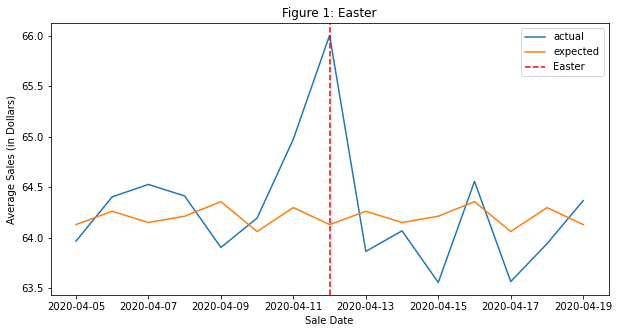

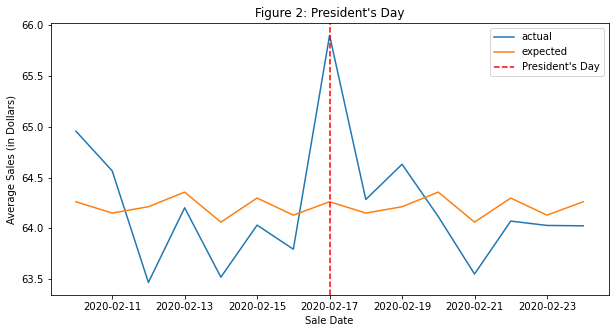

In [12]:
figure_num = 1
for holiday_index in [3,2]:
    best_holiday_plot_df = results[results['closest_holiday'] == holiday_descriptions[holiday_index]]
    plt.figure(figsize=(10,5))
    plt.plot(best_holiday_plot_df.index.values, best_holiday_plot_df['actual'], label='actual')
    plt.plot(best_holiday_plot_df.index.values, best_holiday_plot_df['expected'], label='expected')
    plt.title('Figure ' + str(figure_num) + ': ' + holiday_descriptions[holiday_index])
    plt.xlabel('Sale Date')
    plt.ylabel('Average Sales (in Dollars)')
    plt.axvline(x=df_holidays['holiday_date'][holiday_index], label=holiday_descriptions[holiday_index], color='r', linestyle='--')
    plt.legend()
    figure_num += 1
plt.show()

## Our Worst Holidays

Our analysis revealed that MLK Day and Memorial Day were our least successful holidays.

**MLK Day:** From the plot below for MLK, you can see that the majority of average sales for the MLK holiday window are below the expected average sales. Out of all sale dates in 2020, the sale date January 17, three days before MLK Day, had the most negative deviation from expected average sales. However, there was no dip in sales in the days leading up to and following MLK Day. That is, MLK Day did not worsen sales since average sales fluctuated throughout the holiday window.

**Memorial Day:** Our analysis of Memorial Day is similar to MLK: you can see in the plot that the majority of average sales for the Memorial Day holiday window are below the expected average sales. There also was no dip in sales in the days leading up to and following Memorial Day.

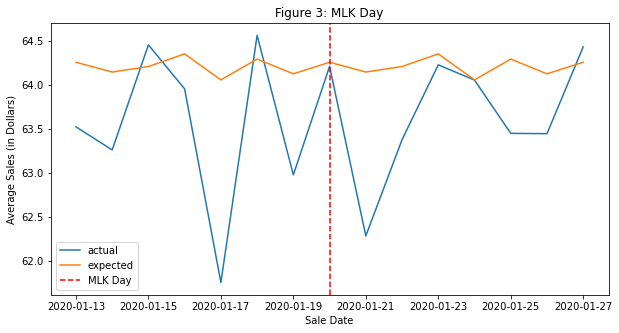

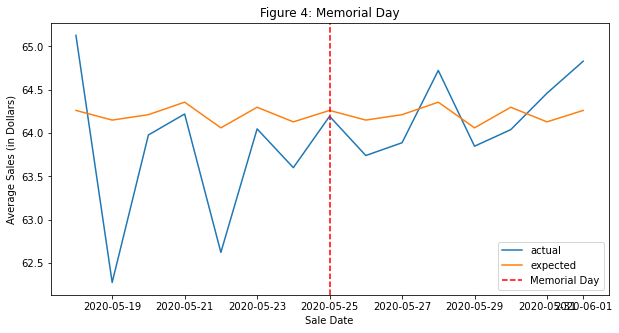

In [13]:
figure_num = 3
for holiday_index in [1,5]:
    best_holiday_plot_df = results[results['closest_holiday'] == holiday_descriptions[holiday_index]]
    plt.figure(figsize=(10,5))
    plt.plot(best_holiday_plot_df.index.values, best_holiday_plot_df['actual'], label='actual')
    plt.plot(best_holiday_plot_df.index.values, best_holiday_plot_df['expected'], label='expected')
    plt.title('Figure ' + str(figure_num) + ': ' + holiday_descriptions[holiday_index])
    plt.xlabel('Sale Date')
    plt.ylabel('Average Sales (in Dollars)')
    plt.axvline(x=df_holidays['holiday_date'][holiday_index], label=holiday_descriptions[holiday_index], color='r', linestyle='--')
    plt.legend()
    figure_num += 1
plt.show()

## Conclusion

The holiday analysis provides a good starting point for improving our sales during the holidays. We can leverage our knowledge of our best holidays in 2020, Easter and President’s Day, to keep sales up. For our worst holidays, MLK Day and Memorial Day, it is worth investigating further to learn why average sales are lower than normal on those holiday windows and develop ways to increase customer or employee engagement during that time to increase sales. Overall, knowledge of our most and least successful holidays provide an excellent business opportunity to improve the growth of AGM.